In [71]:
from os import listdir
from os.path import join, isfile
from deap import base, creator, tools, algorithms

import random
import numpy as np
import matplotlib.pyplot as plt

plt_styles = plt.style.available
plt.style.use(plt_styles[7])


In [72]:
def get_data_from_file(path: str):
    with open(path, "r") as f:
        data = []
        lines = f.readlines()
        for line in lines:
            data.append([int(c) for c in line.split()])
        return data


def get_paths_of_dir(path: str, extension: str):
    return [join(path, f) for f in listdir(path)
            if isfile(join(path, f)) and f.endswith(extension)]
    

In [73]:
inDirPath = "../../Input/"
inPaths = get_paths_of_dir(inDirPath, extension=".in")

In [74]:
n_problem = int(input(f"Elige el problema (1-{len(inPaths)}): "))

inDirFiles = listdir(inDirPath)
file_name = inDirFiles[n_problem - 1]

path = inPaths[n_problem - 1]
prob = get_data_from_file(path)

## Variable meanings.

* R = Number of rows.
* C = Number of columns.
* F = Number of cars.
* N = Pre-booked rides.
* B = Per-ride bonus for starting the ride on time.
* T = Simulation steps = distance between start and end.

In [75]:
# Problem data.
_, _, F, N, B, T = prob[0]

# Rides.
rides = prob[1:-1]

# Car accessibility.
adapted = prob[-1]

Bonus:
* Earn points proportional to distance of ride.
* Bonus if started on time. 

In [76]:
toolbox = base.Toolbox()

In [77]:
if not hasattr(creator, "Fitness"):
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))

if not hasattr(creator, "Individual"):
    creator.create("Individual", list, fitness=creator.FitnessMax)


C:\Users\Ivan\AppData\Local\Programs\Python\Python38\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [78]:
toolbox.register("attribute", random.randint, 0, F - 1)
toolbox.register("individual", tools.initRepeat,
                 creator.Individual, toolbox.attribute, n=N)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [79]:
def sort_rides(car_rides):
    def sort_ride(ride):
        a, b, x, y, s, f, _ = ride
        origin = [a, b]
        destiny = [x, y]
        distance = dis(origin, destiny)

        return s + f - distance

    return sorted(car_rides, key=lambda ride: sort_ride(ride[1]))


def get_rides_from_ind(individual):
    cars_rides = np.full(F, None)

    for i, car in enumerate(individual):
        v_r = cars_rides[car]

        if v_r is None:
            v_r = []

        ride = rides[i]
        v_r.append([i, ride])

        cars_rides[car] = v_r

    return cars_rides


def dis(a, b): return np.abs(a[0] - b[0]) + np.abs(a[1]-b[1])


In [80]:


def calc_fitness(car_rides):
    fitness = 0
    step = 0
    pos = [0, 0]

    # Sort car_rides given earliest time.
    car_rides = sort_rides(car_rides)

    for _, ride in car_rides:
        a, b, x, y, earliest_start, latest_finish, _ = ride
        origin = [a, b]
        destiny = [x, y]

        # 1.- Go to origin.
        step += dis(pos, origin)

        # 2.- If arrived before the earliest time. Wait and earn bonus.
        if step <= earliest_start:
            fitness += B
            step = earliest_start

        # 3.- Go to destiny.
        dis_ori_des = dis(origin, destiny)
        step += dis_ori_des

        # 4.- If reached destiny before latest finish. Earn points.
        if step <= latest_finish:
            fitness += dis_ori_des

        # 5.- Update position.
        pos = destiny

        # 6.- Check if reached max distance with one car.
        if step > T:
            break

    return fitness


def eval_ind(ind):
    all_rides = get_rides_from_ind(ind)

    fitness = 0

    for _, car_rides in enumerate(all_rides):
        if car_rides is not None:
            _fitness = calc_fitness(car_rides)
            fitness += _fitness

    return fitness,


In [81]:
TOURNSIZE = 3
INDPB = 0.2

toolbox.register("select", tools.selTournament, tournsize=TOURNSIZE)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutUniformInt, indpb=INDPB, low=0, up=F-1)
toolbox.register("evaluate", eval_ind)


In [82]:
def get_penalty(ind):
    pen = 0

    for i_ride, i_car in enumerate(ind):
        adapted_ride = rides[i_ride][-1]
        adapted_car = adapted[i_car]

        if adapted_car == 0 and adapted_ride == 1:
            pen += 1

    return pen


def distance(ind):
    pen = get_penalty(ind)
    return pen


def feasible(ind):
    pen = get_penalty(ind)
    return pen == 0


![Constraints](https://deap.readthedocs.io/en/master/_images/constraints.png)

In [83]:
DISTANCE_OFFSET = 0

toolbox.decorate("evaluate", tools.DeltaPenality(
    feasible, DISTANCE_OFFSET, distance))


In [84]:
NIND = 300

pop = toolbox.population(n=NIND)


In [85]:
ind = toolbox.individual()

print("Individuo")
print(ind[1:20])

print("Individuo ANTES de evaluar")
print(f"Valid: {ind.fitness.valid}")

ind.fitness.values = eval_ind(ind)

print("Individuo TRAS evaluar")
print(f"Valid: {ind.fitness.valid}. Fitness = {ind.fitness.values}")


Individuo
[52, 51, 53, 88, 59, 54, 99, 13, 43, 8, 58, 87, 62, 10, 3, 35, 13, 34, 2]
Individuo ANTES de evaluar
Valid: False
Individuo TRAS evaluar
Valid: True. Fitness = (167954.0,)


In [86]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("std", np.std)
stats.register("avg", np.average)


In [87]:
NGEN = 50
CXPB = 0.8
MUTPB = 0.1

pop, logbook = algorithms.eaSimple(
    pop, toolbox, CXPB, MUTPB, NGEN, stats, verbose=False)

In [88]:
best_sol = tools.selBest(pop, k=1)[0]

print(f"El resultado de la evolución es:")
print(logbook)
print(
    f"Mejor solución es {best_sol[1:10]} con fitness {eval_ind(best_sol)}")


El resultado de la evolución es:
gen	nevals	min	max	std    	avg     
0  	300   	-78	-54	4.23914	-66.58  
1  	262   	-73	-51	3.73543	-63.2767
2  	252   	-72	-49	3.81435	-60.1933
3  	245   	-66	-46	3.56604	-56.9967
4  	245   	-65	-46	3.0541 	-54.15  
5  	246   	-63	-44	3.37411	-52.0933
6  	246   	-61	-43	3.20611	-49.9133
7  	252   	-57	-41	2.61805	-47.75  
8  	244   	-58	-38	2.40801	-45.8533
9  	261   	-55	-39	2.70836	-44.41  
10 	247   	-56	-36	2.72546	-42.9567
11 	228   	-54	-36	2.68114	-41.3133
12 	257   	-51	-34	2.67693	-39.6933
13 	254   	-49	-31	2.86294	-38.06  
14 	244   	-45	-29	2.6135 	-36.36  
15 	252   	-48	-27	2.96656	-34.8867
16 	237   	-47	-27	2.80424	-33.23  
17 	245   	-45	-25	2.85201	-31.9033
18 	249   	-46	-24	3.27085	-30.8133
19 	248   	-46	-24	3.074  	-29.4767
20 	252   	-40	-22	2.83222	-28.0433
21 	245   	-42	-22	3.19692	-26.92  
22 	237   	-41	-21	2.89233	-25.3667
23 	258   	-37	-21	2.81359	-24.48  
24 	234   	-41	-21	3.04754	-23.65  
25 	253   	-37	-19	3.14356	-22.

Min pen: 9.0


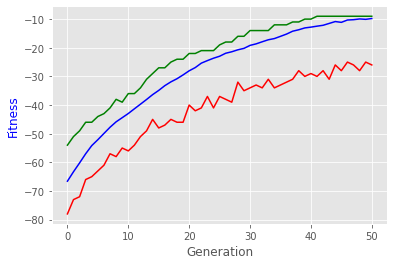

In [89]:
def plot_pen_fitness(lb):
    gen = lb.select("gen")
    avgs = lb.select("avg")
    maxs = lb.select("max")
    mins = lb.select("min")

    print(f"Min pen: {abs(max(maxs))}")

    _, ax = plt.subplots()

    ax.plot(gen, avgs, "g-", label="Average Fitness")
    ax.plot(gen, maxs, "r-", label="Average Fitness")
    ax.plot(gen, mins, "b-", label="Average Fitness")
    ax.set_xlabel("Generation")
    ax.set_ylabel("Fitness", color="b")

    plt.show()


plot_pen_fitness(logbook)


In [90]:
outDirPath = "../../Output/"
outFilePath = outDirPath + file_name.strip(".in") + ".out"

cars_rides = get_rides_from_ind(best_sol)

with open(outFilePath, "w") as f:
    for v_r in cars_rides:
      if v_r is None:
        f.write(str(0))
      else:
        v_r = sort_rides(v_r)    
        f.write(str(len(v_r)))
        f.write(" ")
        f.write(" ".join(str(pos) for pos, _ in v_r))
      
      f.write("\n")